In [18]:
# ==========================================================
# A. DATA COLLECTION
# ==========================================================
# Dataset: COVID-19 Indonesia Time Series All
# Sumber resmi: https://data.covid19.go.id (dataset publik)
# Deskripsi: Berisi data perkembangan COVID-19 di seluruh provinsi Indonesia
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu, pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler

# Baca dataset
df = pd.read_csv("covid_19_indonesia_time_series_all.csv")

print("=== Info Awal Dataset ===")
print(df.info())
print("\nContoh data:")
print(df.head())
    
print("\nJumlah baris:", len(df))
print("Jumlah kolom:", len(df.columns))
print("\nKolom dataset:", df.columns.tolist())
print("\nNilai unik pada kolom 'Location Level':", df["Location Level"].unique())

=== Info Awal Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31822 entries, 0 to 31821
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         31822 non-null  object 
 1   Location ISO Code            31822 non-null  object 
 2   Location                     31822 non-null  object 
 3   New Cases                    31822 non-null  int64  
 4   New Deaths                   31822 non-null  int64  
 5   New Recovered                31822 non-null  int64  
 6   New Active Cases             31822 non-null  int64  
 7   Total Cases                  31822 non-null  int64  
 8   Total Deaths                 31822 non-null  int64  
 9   Total Recovered              31822 non-null  int64  
 10  Total Active Cases           31822 non-null  int64  
 11  Location Level               31822 non-null  object 
 12  City or Regency              0 non-null      flo

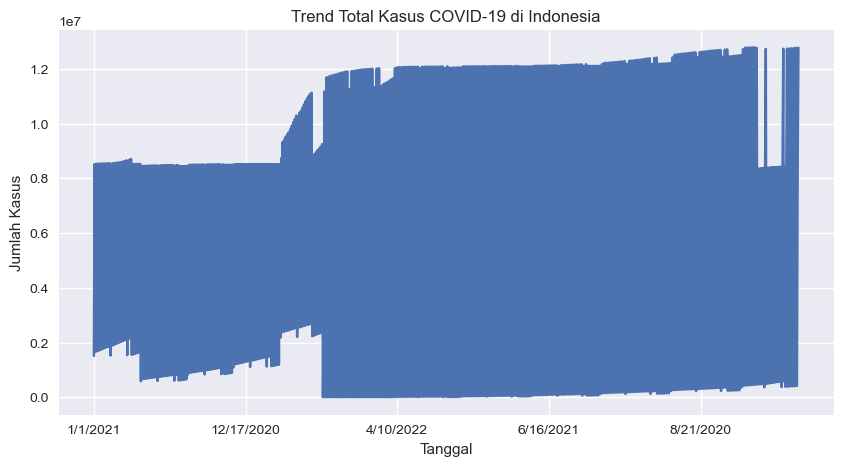

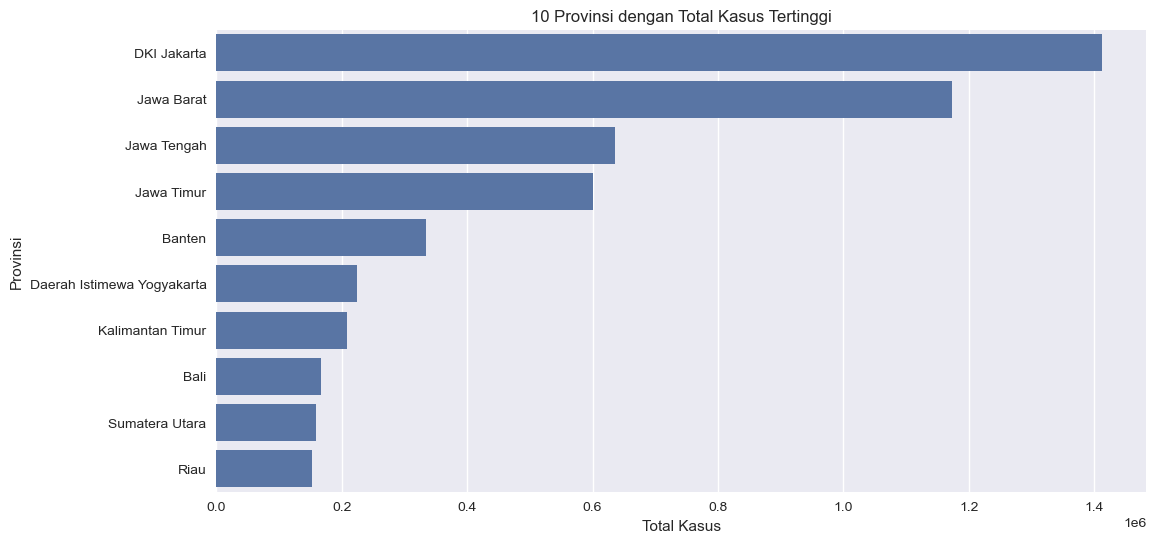

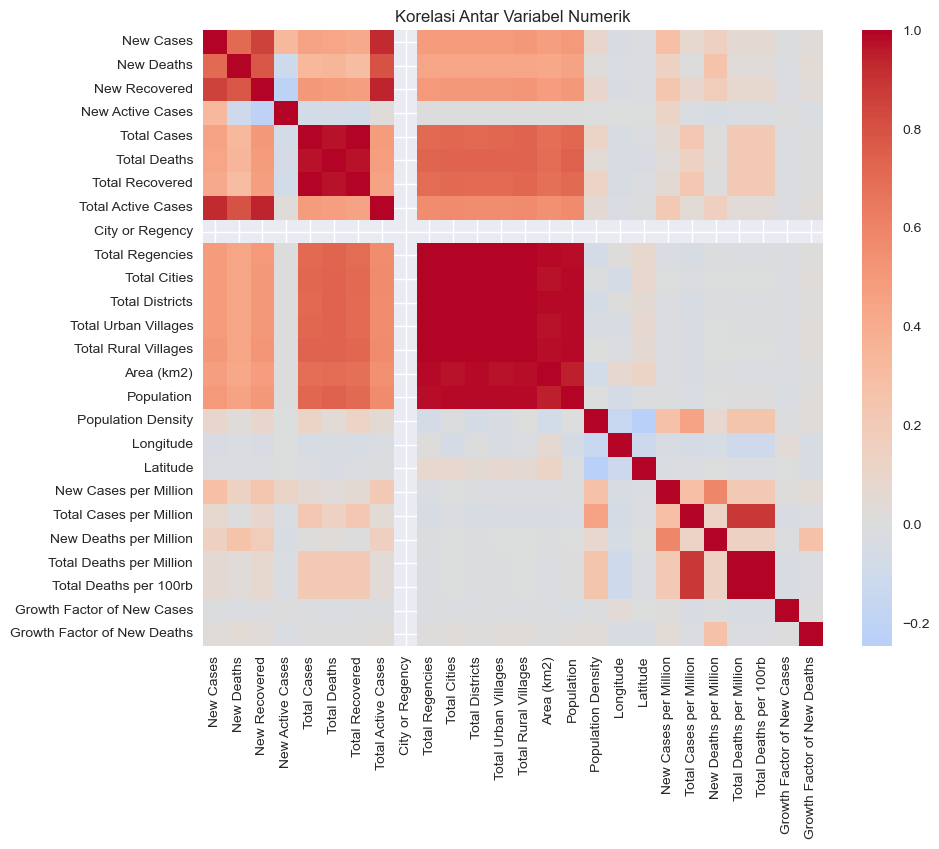

In [19]:
# ==========================================================
# B. DATA VISUALIZATION - Before
# ==========================================================
# 1️⃣ Alasan visualisasi:
#    - Line plot: menunjukkan tren waktu kasus nasional.
#    - Bar chart: membandingkan provinsi dengan kasus tertinggi.
#    - Heatmap: menampilkan korelasi antar variabel numerik.
# 2️⃣ Terdapat minimal 3 jenis visualisasi berbeda.
# ==========================================================

plt.style.use("seaborn-v0_8")

# --- Line plot: Tren total kasus nasional ---
plt.figure(figsize=(10,5))
df.groupby("Date")["Total Cases"].sum().plot()
plt.title("Trend Total Kasus COVID-19 di Indonesia")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Kasus")
plt.grid(True)
plt.show()

# --- Bar chart: 10 provinsi dengan total kasus tertinggi ---
plt.figure(figsize=(12,6))
top_cases = df.groupby("Province")["Total Cases"].max().sort_values(ascending=False).head(10)
sns.barplot(x=top_cases.values, y=top_cases.index)
plt.title("10 Provinsi dengan Total Kasus Tertinggi")
plt.xlabel("Total Kasus")
plt.ylabel("Provinsi")
plt.show()

# --- Heatmap: Korelasi antar variabel numerik ---
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Korelasi Antar Variabel Numerik")
plt.show()


In [20]:
# ==========================================================
# C. DATA PROCESSING AND TECHNIQUES
# ==========================================================
# Teknik yang digunakan:
# 1️⃣ Handling Missing Values → imputasi konteksual.
# 2️⃣ Feature Scaling → Standardization.
# 3️⃣ Handling Outliers → metode IQR.
# ==========================================================

# --- Filter level provinsi ---
df = df[df["Location Level"] == "Province"]

# --- Hapus kolom tidak relevan ---
df.drop(columns=["City or Regency"], errors="ignore", inplace=True)

# --- Konversi kolom tanggal ---
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"])

# --- Bersihkan kolom persentase ---
df["Case Fatality Rate"] = df["Case Fatality Rate"].astype(str).str.replace("%", "").astype(float)
df["Case Recovered Rate"] = df["Case Recovered Rate"].astype(str).str.replace("%", "").astype(float)

# --- Handling Missing Values ---
df["Total Rural Villages"] = df["Total Rural Villages"].fillna(0)
df["Growth Factor of New Deaths"] = df["Growth Factor of New Deaths"].fillna(1.0)
df["Growth Factor of New Cases"] = df["Growth Factor of New Cases"].fillna(1.0)

# --- Feature Engineering ---
df["Case Fatality Rate (calc)"] = (df["Total Deaths"] / df["Total Cases"]) * 100
df["Case Recovered Rate (calc)"] = (df["Total Recovered"] / df["Total Cases"]) * 100
df["Death to Recovery Ratio"] = df["Total Deaths"] / (df["Total Recovered"] + 1)
df["Active Case Ratio"] = df["Total Active Cases"] / df["Total Cases"]
df["Cases per 100k"] = (df["Total Cases"] / df["Population"]) * 100000

print("\n✅ Feature engineering selesai. Contoh data:")
print(df.head())

# --- Feature Scaling (Standardization) ---
scaler = StandardScaler()
cols_to_scale = ["Total Cases", "Total Deaths", "Total Recovered", "Population Density"]
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])
print("\n✅ Normalisasi berhasil dilakukan pada kolom numerik utama.")

# --- Handling Outliers (IQR Method) ---
Q1 = df["Total Cases"].quantile(0.25)
Q3 = df["Total Cases"].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df = df[(df["Total Cases"] >= lower) & (df["Total Cases"] <= upper)]
print("✅ Outlier dihapus berdasarkan IQR (Total Cases)")



✅ Feature engineering selesai. Contoh data:
        Date Location ISO Code     Location  New Cases  New Deaths  \
0 2020-03-01             ID-JK  DKI Jakarta          2           0   
1 2020-03-02             ID-JK  DKI Jakarta          2           0   
3 2020-03-02             ID-RI         Riau          1           0   
4 2020-03-03             ID-JK  DKI Jakarta          2           0   
6 2020-03-03             ID-JB   Jawa Barat          1           1   

   New Recovered  New Active Cases  Total Cases  Total Deaths  \
0              0                 2           39            20   
1              0                 2           41            20   
3              0                 1            1             0   
4              0                 2           43            20   
6              0                 0            1             1   

   Total Recovered  ...  Total Deaths per 100rb Case Fatality Rate  \
0               75  ...                    0.18              51.28   
1  

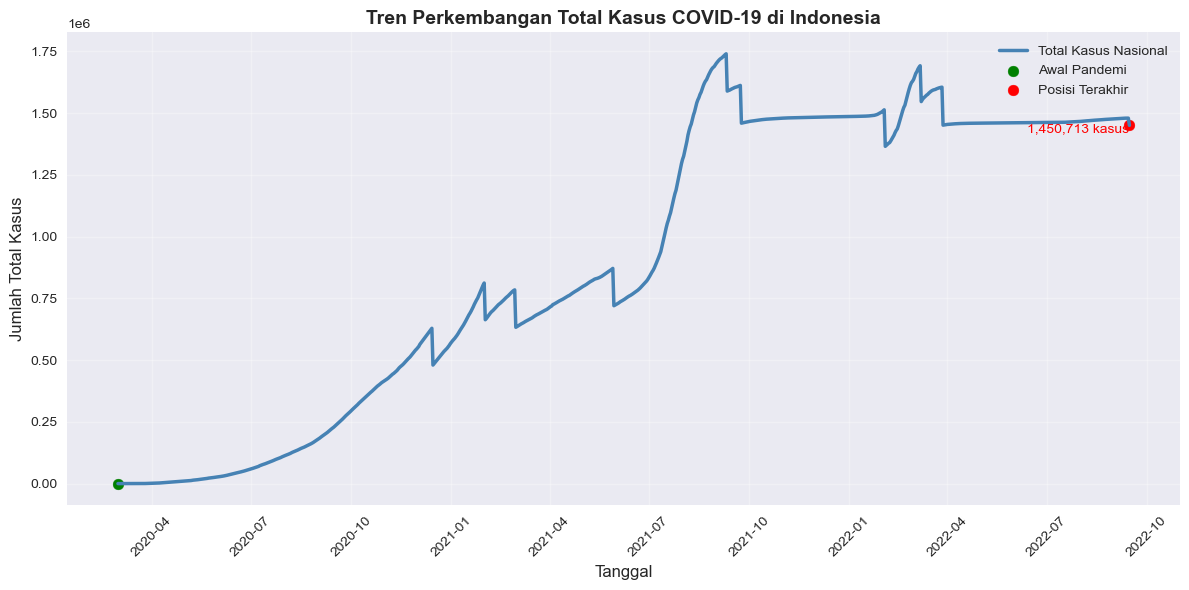

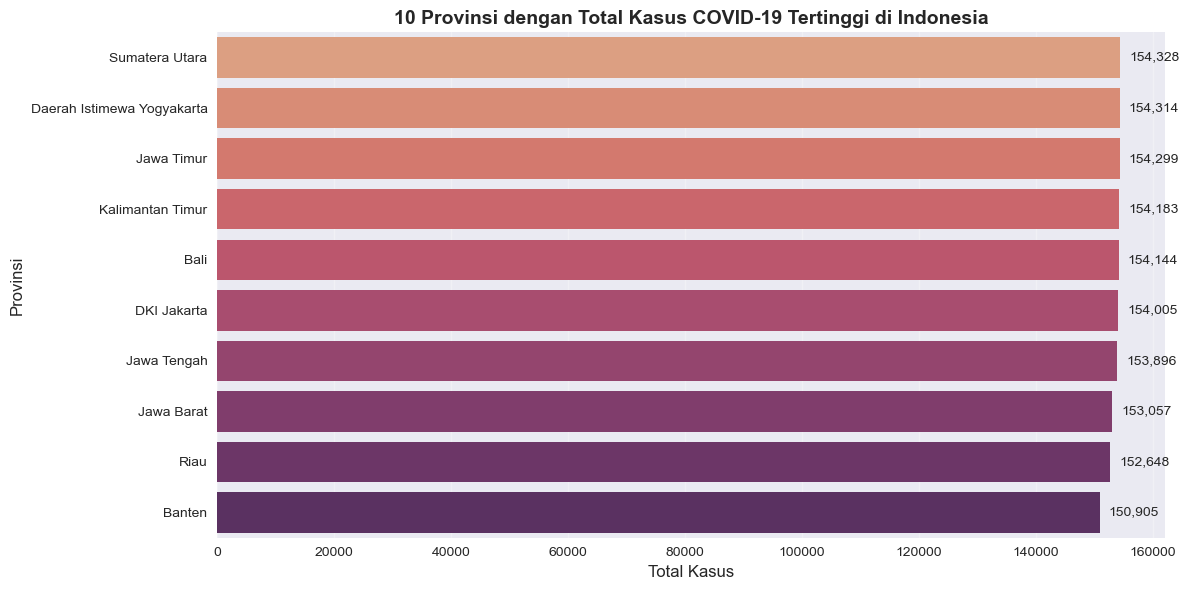

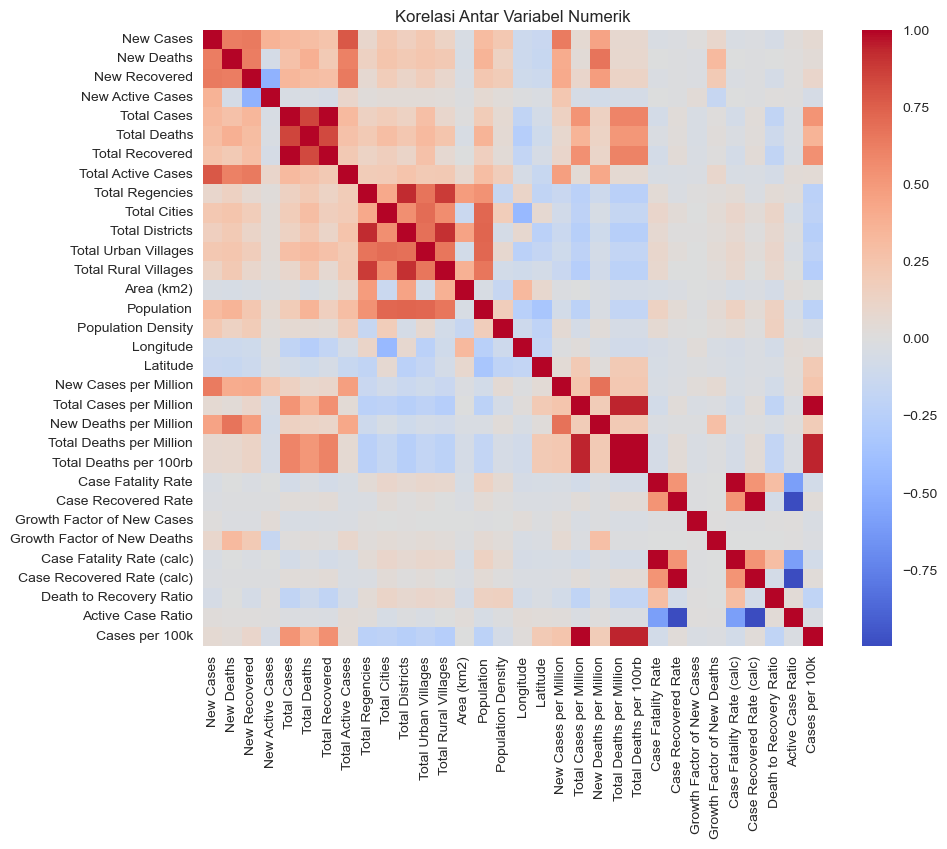

In [21]:
# ==========================================================
# D. DATA VISUALIZATION - After
# ==========================================================
# 1️⃣ Alasan visualisasi:
#    - Line plot: menunjukkan tren waktu kasus nasional.
#    - Bar chart: membandingkan provinsi dengan kasus tertinggi.
#    - Heatmap: menampilkan korelasi antar variabel numerik.
# 2️⃣ Terdapat minimal 3 jenis visualisasi berbeda.
# ==========================================================

plt.style.use("seaborn-v0_8")

# --- Line Plot: Tren Perkembangan Kasus COVID-19 Nasional ---
plt.figure(figsize=(12,6))
trend_cases = df.groupby("Date")["Total Cases"].sum().reset_index()

plt.plot(trend_cases["Date"], trend_cases["Total Cases"], color="steelblue", linewidth=2.5, label="Total Kasus Nasional")
plt.scatter(trend_cases["Date"].iloc[0], trend_cases["Total Cases"].iloc[0], color="green", s=60, label="Awal Pandemi")
plt.scatter(trend_cases["Date"].iloc[-1], trend_cases["Total Cases"].iloc[-1], color="red", s=60, label="Posisi Terakhir")
plt.text(trend_cases["Date"].iloc[-1], trend_cases["Total Cases"].iloc[-1]*0.98,
         f"{trend_cases['Total Cases'].iloc[-1]:,.0f} kasus", fontsize=10, color="red", ha="right")
plt.title("Tren Perkembangan Total Kasus COVID-19 di Indonesia", fontsize=14, fontweight="bold")
plt.xlabel("Tanggal", fontsize=12)
plt.ylabel("Jumlah Total Kasus", fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Bar chart: 10 provinsi dengan total kasus tertinggi ---
plt.figure(figsize=(12,6))

top_cases = (
    df.groupby("Province")["Total Cases"]
      .max()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
)

sns.barplot(
    data=top_cases,
    x="Total Cases",
    y="Province",
    hue="Province",         # tambahkan hue agar sesuai standar
    palette="flare",
    dodge=False,
    legend=False            # agar tidak muncul legenda ganda
)

# Tambahkan label nilai di ujung bar
for index, value in enumerate(top_cases["Total Cases"]):
    plt.text(value + (value * 0.01), index, f"{int(value):,}", va='center')

plt.title("10 Provinsi dengan Total Kasus COVID-19 Tertinggi di Indonesia", fontsize=14, fontweight="bold")
plt.xlabel("Total Kasus", fontsize=12)
plt.ylabel("Provinsi", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


# --- Heatmap: Korelasi antar variabel numerik ---
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Korelasi Antar Variabel Numerik")
plt.show()


In [22]:
# ==========================================================
# E. STATISTICAL ANALYSIS
# ==========================================================
# 1️⃣ Uji Parametrik: ANOVA, T-Test, Pearson Correlation
# 2️⃣ Uji Non-Parametrik: Mann-Whitney U, Spearman Correlation
# ==========================================================

from scipy.stats import f_oneway, ttest_ind, mannwhitneyu, pearsonr, spearmanr

# --- ANOVA antar 3 provinsi ---
prov_list = ['DKI Jakarta', 'Jawa Barat', 'Jawa Tengah']
df_prov = df[df["Province"].isin(prov_list)]

data_jakarta = df_prov[df_prov["Province"] == "DKI Jakarta"]["Total Cases"]
data_jabar = df_prov[df_prov["Province"] == "Jawa Barat"]["Total Cases"]
data_jateng = df_prov[df_prov["Province"] == "Jawa Tengah"]["Total Cases"]

f_stat, p_val = f_oneway(data_jakarta, data_jabar, data_jateng)
print("\n=== Uji ANOVA (Total Kasus antar Provinsi) ===")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4e}")

# Effect size (Eta Squared)
eta_squared = f_stat * (len(df_prov) - len(prov_list)) / (f_stat * (len(df_prov) - len(prov_list)) + (len(prov_list) - 1))
print(f"Effect Size (Eta Squared): {eta_squared:.3f}")

if p_val < 0.05:
    print("👉 Ada perbedaan signifikan jumlah kasus antar provinsi.")
else:
    print("👉 Tidak ada perbedaan signifikan jumlah kasus antar provinsi.")

# --- Uji T-test dan Mann-Whitney ---
prov1 = df[df["Province"] == "DKI Jakarta"]["New Cases"]
prov2 = df[df["Province"] == "Jawa Barat"]["New Cases"]

if not prov1.empty and not prov2.empty:
    # Parametrik: T-test
    t_stat, p_val_t = ttest_ind(prov1, prov2, nan_policy='omit')
    print(f"\nT-test (New Cases DKI Jakarta vs Jawa Barat): t={t_stat:.3f}, p={p_val_t:.3e}")
    
    # Non-parametrik: Mann-Whitney
    u_stat, p_val_u = mannwhitneyu(prov1, prov2, alternative="two-sided")
    print(f"Mann-Whitney U Test: U={u_stat:.3f}, p={p_val_u:.3e}")
else:
    print("\n⚠️ Data tidak tersedia untuk provinsi tertentu.")

# --- Korelasi ---
cases = df["Total Cases"]
deaths = df["Total Deaths"]
recovered = df["Total Recovered"]

pearson_corr, _ = pearsonr(cases, deaths)
spearman_corr, _ = spearmanr(cases, recovered)

def interpret_corr(r):
    if abs(r) < 0.3:
        return "lemah"
    elif abs(r) < 0.7:
        return "sedang"
    else:
        return "kuat"

print(f"\nKorelasi Pearson (Kasus vs Kematian): {pearson_corr:.3f} ({interpret_corr(pearson_corr)})")
print(f"Korelasi Spearman (Kasus vs Sembuh): {spearman_corr:.3f} ({interpret_corr(spearman_corr)})")



=== Uji ANOVA (Total Kasus antar Provinsi) ===
F-Statistic: 8.6112
P-value: 1.9621e-04
Effect Size (Eta Squared): 1.000
👉 Ada perbedaan signifikan jumlah kasus antar provinsi.

T-test (New Cases DKI Jakarta vs Jawa Barat): t=1.601, p=1.100e-01
Mann-Whitney U Test: U=59088.000, p=1.973e-06

Korelasi Pearson (Kasus vs Kematian): 0.850 (kuat)
Korelasi Spearman (Kasus vs Sembuh): 0.996 (kuat)


In [24]:
# ==========================================================
# SIMPAN DATA BERSIH
# ==========================================================
df.to_csv("covid_clean2.csv", index=False)
print("\n✅ Dataset bersih berhasil disimpan ke 'covid_clean2.csv'")


✅ Dataset bersih berhasil disimpan ke 'covid_clean2.csv'
